In [ ]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q
!pip install opendatasets -q
!pip install opencv-python -q
!pip install gdown
!pip install PyDrive

In [ ]:
#import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import opendatasets as od
import gdown

In [ ]:
# Download the dataset
od.download("https://www.kaggle.com/datasets/harshwalia/birds-vs-drone-dataset")
od.download("https://www.kaggle.com/datasets/imbikramsaha/drone-bird-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hasithachathuranga
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/harshwalia/birds-vs-drone-dataset


100%|██████████| 78.1M/78.1M [00:00<00:00, 134MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hasithachathuranga
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/drone-bird-classification


100%|██████████| 40.0M/40.0M [00:00<00:00, 153MB/s]


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [ ]:
train_data_dir = "/content/drive/MyDrive/BirdVsDrone/Train"
test_data_dir = "/content/drive/MyDrive/BirdVsDrone/Test"

In [ ]:
# Load the dataset
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size= IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                              batch_size=BATCH_SIZE,
                                                              image_size=IMAGE_SIZE,
                                                              subset='validation',
                                                              validation_split=0.1,
                                                              seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMAGE_SIZE)

Found 666 files belonging to 2 classes.
Using 600 files for training.
Found 666 files belonging to 2 classes.
Using 66 files for validation.
Found 160 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names
class_names

['Birds', 'Drones']

In [ ]:
# Normalize the data
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Train the model
start_time = time.time()

history = model.fit(train_data,
                    epochs=20,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/20
19/19 [==============================] - 69s 2s/step - loss: 0.6093 - accuracy: 0.7117 - val_loss: 0.6465 - val_accuracy: 0.7727
Epoch 2/20
19/19 [==============================] - 22s 1s/step - loss: 0.4039 - accuracy: 0.8150 - val_loss: 0.5850 - val_accuracy: 0.8030
Epoch 3/20
19/19 [==============================] - 27s 1s/step - loss: 0.4043 - accuracy: 0.8333 - val_loss: 0.6336 - val_accuracy: 0.6364
Epoch 4/20
19/19 [==============================] - 23s 1s/step - loss: 0.4308 - accuracy: 0.8050 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/20
19/19 [==============================] - 22s 1s/step - loss: 0.2788 - accuracy: 0.8800 - val_loss: 0.5886 - val_accuracy: 0.6818
Epoch 6/20
19/19 [==============================] - 22s 1s/step - loss: 0.2083 - accuracy: 0.9100 - val_loss: 0.5129 - val_accuracy: 0.7576
Epoch 7/20
19/19 [==============================] - 25s 1s/step - loss: 0.2126 - accuracy: 0.9167 - val_loss: 0.4797 - val_accuracy: 0.7424
Epoch 8/20
19/19 [==

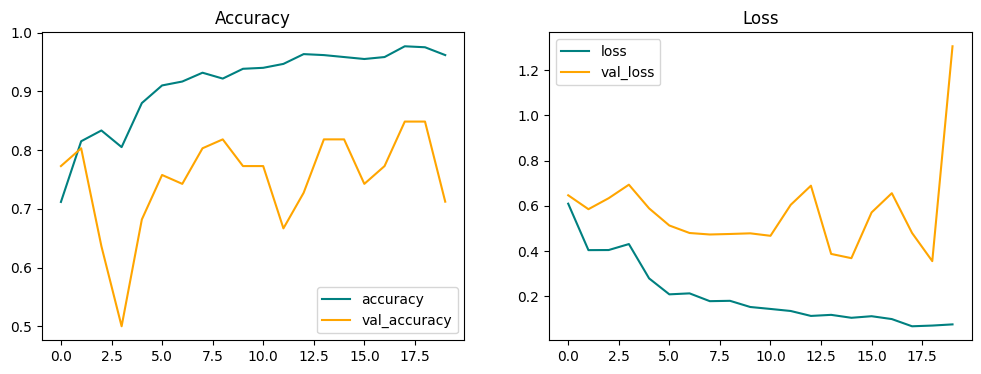

In [ ]:
# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['accuracy'], color='teal', label='accuracy')
axs[0].plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
axs[0].set_title('Accuracy')
axs[0].legend()

axs[1].plot(history.history['loss'], color='teal', label='loss')
axs[1].plot(history.history['val_loss'], color='orange', label='val_loss')
axs[1].set_title('Loss')
axs[1].legend()

plt.show()

In [ ]:
# Evaluate model performance on test data
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

y_true = []
y_pred_probs = []

for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_true.extend(y)
    y_pred_probs.extend(yhat)

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int)

precision.update_state(y_true, y_pred_probs)
recall.update_state(y_true, y_pred_probs)
accuracy.update_state(y_true, y_pred_probs)

# Calculate F1 Score
precision_val = precision.result().numpy()
recall_val = recall.result().numpy()
f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)

print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')
print(f'Accuracy: {accuracy.result().numpy()}')
print(f"F1 Score: {f1_score_val}")

1/1 [==============================] - 0s 247ms/step
Precision: 0.572519063949585
Recall: 0.9375
Accuracy: 0.6187499761581421
F1 Score: 0.7109004387635927


In [ ]:
# Function to plot ROC curves
def plot_roc_curve(y_true, y_scores, label):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

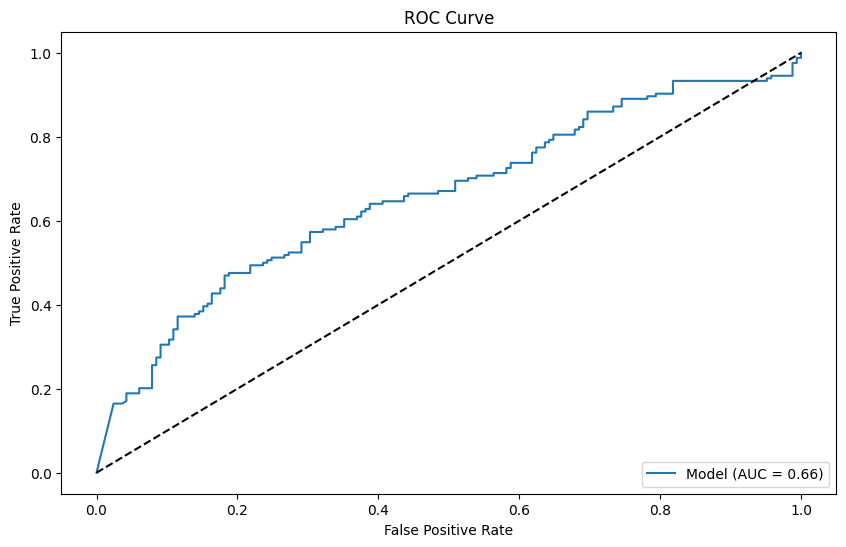

In [ ]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plot_roc_curve(y_true, y_pred_probs, 'Model')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

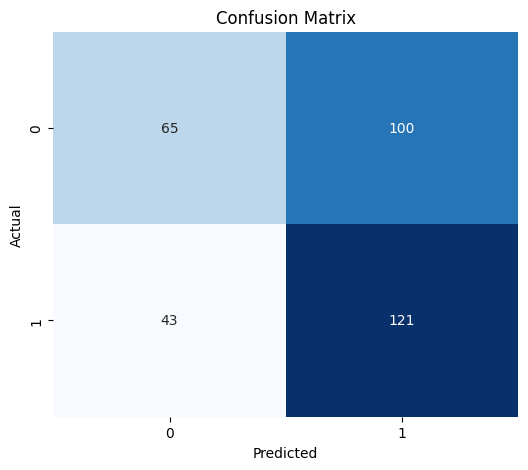

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix')

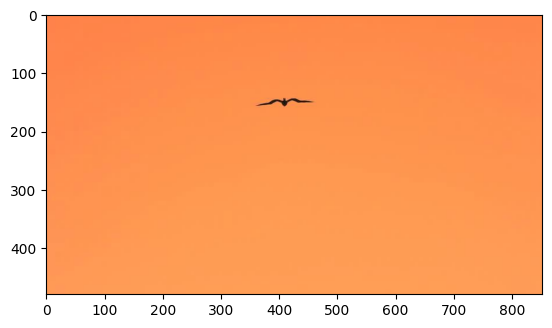

1/1 [==============================] - 0s 28ms/step
Birds


In [ ]:
# Predict on a sample image
import cv2

image = cv2.imread("/content/birds-vs-drone-dataset/BirdVsDrone/Birds/singleBirdinsky1.jpeg")
plt.imshow(image)
plt.show()

resized_image = tf.image.resize(image, IMAGE_SIZE)
scaled_image = resized_image / 255.0

y_hat = model.predict(np.expand_dims(scaled_image, 0))

if y_hat >= 0.5:
    print(class_names[1])
else:
    print(class_names[0])